In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'regression/Plots_quantile/'
modelpath_c = path_prefix+'classifier/Models/'
modelpath = path_prefix+'regression/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
import uproot as ur

Using TensorFlow backend.


In [4]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model
import keras.backend as K

In [5]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [6]:
# import pi+

inputpath = path_prefix+'inputs/'
ptypes = ["pi0", "piplus"]
trees = {
    ptype : ur.open(inputpath+ptype+'.root')['ClusterTree']
    for ptype in ptypes
}
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pdata = {
    ptype : itree.pandas.df(branches, flatten=False)
    for ptype, itree in trees.items()
}

print("Number of pi0 events: {}".format(len(pdata['pi0'])))
print("Number of pi+ events: {}".format(len(pdata['piplus'])))

Number of pi0 events: 263891
Number of pi+ events: 435967


In [7]:
#define convenience columns
for ptype in ptypes:
    pdata[ptype]['clusterEoverCalib'] = pdata[ptype].clusterE / pdata[ptype].cluster_ENG_CALIB_TOT
    pdata[ptype]['clusterEoverTruth'] = pdata[ptype].clusterE / pdata[ptype].truthE
    pdata[ptype]['cluster_ENG_ALL'] = pdata[ptype].cluster_ENG_CALIB_TOT + pdata[ptype].cluster_ENG_CALIB_OUT_T + pdata[ptype].cluster_ENG_CALIB_DEAD_TOT

In [8]:
# regression variables: define up here to make it easier for later swapping

for ptype in ptypes:
    pdata[ptype]['logE'] = np.log(pdata[ptype].clusterE)
    pdata[ptype]['logECalib'] = np.log(pdata[ptype].cluster_ENG_CALIB_TOT)
    pdata[ptype]['logECalibAll'] = np.log(pdata[ptype].cluster_ENG_ALL)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler_cal = {}
for ptype in ptypes:
    # create scaler
    scaler_e = StandardScaler()
    scaler_cal[ptype] = StandardScaler()
    scaler_calAll = StandardScaler()
    # fit and transform in one step
    pdata[ptype]['s_logE'] = scaler_e.fit_transform(pdata[ptype]['logE'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalib'] = scaler_cal[ptype].fit_transform(pdata[ptype]['logECalib'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalibAll'] = scaler_calAll.fit_transform(pdata[ptype]['logECalibAll'].to_numpy().reshape(-1,1))


In [10]:
# fun cleaning for EMProb
epsilon = 0.000000000001

for ptype in ptypes:
    pdata[ptype]['cluster_fixEM'] = pdata[ptype].cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [11]:
for ptype in ptypes:
    pdata[ptype]['cluster_logEM'] = np.log(pdata[ptype].cluster_fixEM)

    scaler_EM = StandardScaler()
    pdata[ptype]['s_logEM'] = scaler_EM.fit_transform(pdata[ptype].cluster_logEM.to_numpy().reshape(-1,1))

    scaler_eta = StandardScaler()
    pdata[ptype]['s_eta'] = scaler_eta.fit_transform(pdata[ptype].clusterEta.to_numpy().reshape(-1,1))

    pdata[ptype]['logCenter'] = np.log(pdata[ptype].cluster_CENTER_MAG)
    scaler_center = StandardScaler()
    pdata[ptype]['s_logCenter'] = scaler_center.fit_transform(pdata[ptype].logCenter.to_numpy().reshape(-1,1))

    scaler_density = StandardScaler()
    pdata[ptype]['s_Density'] = scaler_density.fit_transform(pdata[ptype].cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [12]:
# define convience sub-frames

for ptype in ptypes:
    pdata[ptype]['Single'] = pdata[ptype].nCluster==1 # define a subset of events with only one cluster
    mu.splitFrameTVT(pdata[ptype], trainfrac = 0.7)   # define a train/test fraction of 70/20% (10% for val at this point)

In [13]:
All_input = {}

for ptype in ptypes:
    EMB1_cells = mu.setupCells(trees[ptype], 'EMB1') # implicitly flatten
    EMB2_cells = mu.setupCells(trees[ptype], 'EMB2')
    EMB3_cells = mu.setupCells(trees[ptype], 'EMB3') # implicitly flatten

    TileBar0_cells = mu.setupCells(trees[ptype], 'TileBar0') # implicitly flatten
    TileBar1_cells = mu.setupCells(trees[ptype], 'TileBar1') # implicitly flatten
    TileBar2_cells = mu.setupCells(trees[ptype], 'TileBar2') # implicitly flatten

    combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
    s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
    All_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_All_cells))

In [14]:
quantiles = [0.16, 0.5, 0.84]

def GAE(y_true, y_pred):
    sgn = -(y_true - y_pred) / K.abs(y_true - y_pred)
    return (0.5-sgn*0.5+sgn*0.84)*K.abs(y_true - y_pred)

def get_GAE(q):
    def GAE_q(y_true, y_pred):
#         if( (y_true - y_pred) == 0 ):
#             return 0.0
        sgn = -(y_true - y_pred) / (K.abs(y_true - y_pred)+K.epsilon())
        return (0.5-sgn*0.5+sgn*q)*K.abs(y_true - y_pred)
    return GAE_q

quantile_loss = [
    get_GAE(q) for q in quantiles
]

In [15]:
regressor_q = []
for q,loss in zip(quantiles,quantile_loss):
    def gae_model():
        number_pixels = 512 + 256 + 128 + 16 + 16 +8
        # create model
        with strategy.scope():    
            model = Sequential()
            used_pixels = number_pixels + 2
    #     if number_pixels < 128:
    #         used_pixels = 128
            model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(used_pixels, activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(int(used_pixels/2), activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
            opt = Adam(lr=1e-4, decay=1e-6)
            model.compile(optimizer=opt, loss=loss,metrics=['mae','mse'])

        return model
    
    regressor_q.append(
        KerasRegressor(build_fn=gae_model, batch_size=200*ngpu, epochs=50, verbose=1)
    )

In [19]:
# train models
for rq in regressor_q:
    history = rq.fit(
        All_input['piplus'][pdata['piplus'].train],
        pdata['piplus'][pdata['piplus'].train].s_logECalib.to_numpy()
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Train on 305176 samples
Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/de

305176/305176 [==============================] - 7s 22us/sample - loss: 0.0093 - mae: 0.1533 - mse: 0.0646
Epoch 26/50
305176/305176 [==============================] - 7s 23us/sample - loss: 0.0092 - mae: 0.1527 - mse: 0.0601
Epoch 27/50
305176/305176 [==============================] - 7s 22us/sample - loss: 0.0092 - mae: 0.1524 - mse: 0.0677
Epoch 28/50
305176/305176 [==============================] - 7s 23us/sample - loss: 0.0092 - mae: 0.1513 - mse: 0.0625
Epoch 29/50
305176/305176 [==============================] - 7s 23us/sample - loss: 0.0092 - mae: 0.1517 - mse: 0.0632
Epoch 30/50
305176/305176 [==============================] - 7s 23us/sample - loss: 0.0091 - mae: 0.1501 - mse: 0.0594
Epoch 31/50
305176/305176 [==============================] - 7s 23us/sample - loss: 0.0092 - mae: 0.1519 - mse: 0.0851
Epoch 32/50
305176/305176 [==============================] - 7s 23us/sample - loss: 0.0091 - mae: 0.1502 - mse: 0.0704
Epoch 33/50
305176/305176 [==============================] -

In [28]:
# save models
for rq, q in zip(regressor_q,quantiles):
    rq.model.save(modelpath + 'quantile_' + str(q) + '.h5')

In [16]:
# load models
for rq, q, loss in zip(regressor_q,quantiles,quantile_loss):
    rq.model = load_model(modelpath + 'quantile_' + str(q) + '.h5',
                          custom_objects={'GAE_q':loss}
    )

In [18]:
for rq, q in zip(regressor_q,quantiles):
    pdata['piplus']['quantile_'+str(q)] = np.exp(
        scaler_cal['piplus'].inverse_transform(rq.predict(All_input['piplus']))
    )
    pdata['piplus']['quantile_'+str(q)+'_EoverCalib'] = pdata['piplus']['quantile_'+str(q)] / pdata['piplus'].cluster_ENG_CALIB_TOT
    
#     pdata['piplus']['quantile_'+str(q)] = np.exp(scaler_cal['piplus'].inverse_transform(
#         rq.predict([pdata['piplus'].s_logE.to_numpy()])
#     ))

435967/435967 [==============================] - 3s 7us/sample


<Figure size 576x432 with 0 Axes>

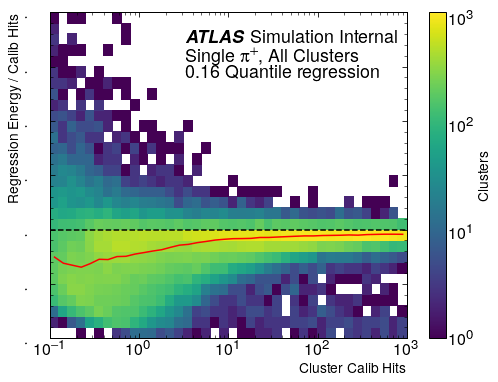

<Figure size 576x432 with 0 Axes>

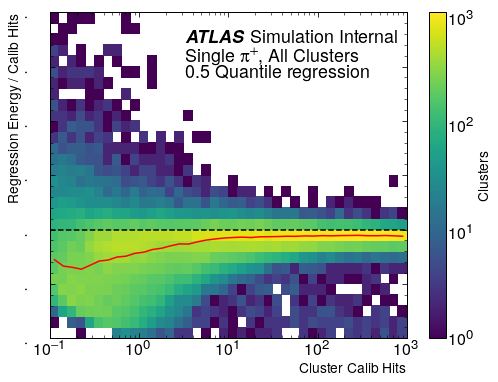

<Figure size 576x432 with 0 Axes>

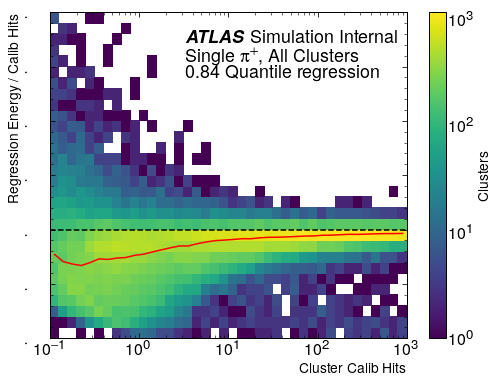

In [41]:
regQuant = []
for q in quantiles:
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test]['quantile_'+str(q)+'_EoverCalib'], 
                      figfile = plotpath+'quantile_'+str(q)+'_response.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Quantile regression'}])
    regQuant.append(rq)

<Figure size 576x432 with 0 Axes>

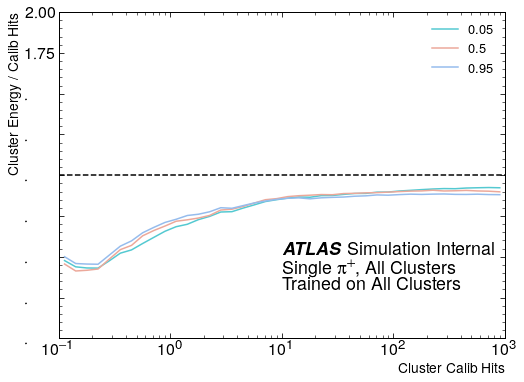

In [22]:
pu.lineOverlay(xcenter=xcenter, lines = regQuant,
                labels = [str(q) for q in quantiles],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "quantile_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

## Quantile Ordering

In [27]:
# seperate training set into upper/lower halves based on network's prediction
# of median energy
pdata_upper = pdata['piplus'].clusterE > pdata['piplus']['quantile_0.5']
pdata_lower = pdata['piplus'].clusterE < pdata['piplus']['quantile_0.5']

In [28]:
ordered_q = []
for q in [pdata_upper, pdata_lower]:
    def gae_model():
        number_pixels = 512 + 256 + 128 + 16 + 16 +8
        # create model
        with strategy.scope():    
            model = Sequential()
            used_pixels = number_pixels + 2
    #     if number_pixels < 128:
    #         used_pixels = 128
            model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(used_pixels, activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(int(used_pixels/2), activation='relu'))
            # model.add(Dropout(0.2))
            model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
            opt = Adam(lr=1e-4, decay=1e-6)
            model.compile(optimizer=opt, loss=get_GAE(0.5),metrics=['mae','mse'])

        return model
    
    ordered_q.append(
        KerasRegressor(build_fn=gae_model, batch_size=200*ngpu, epochs=50, verbose=1)
    )
    
# train models
for m,q in zip(ordered_q, [pdata_upper, pdata_lower]):
    history = m.fit(
        All_input['piplus'][pdata['piplus'].train & q],
        pdata['piplus'][pdata['piplus'].train & q].s_logECalib.to_numpy()
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Train on 206314 samples
Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/de

Epoch 8/50
98862/98862 [==============================] - 2s 21us/sample - loss: 0.0201 - mae: 0.0402 - mse: 0.0050
Epoch 9/50
98862/98862 [==============================] - 2s 22us/sample - loss: 0.0196 - mae: 0.0392 - mse: 0.0048
Epoch 10/50
98862/98862 [==============================] - 2s 22us/sample - loss: 0.0188 - mae: 0.0375 - mse: 0.0047
Epoch 11/50
98862/98862 [==============================] - 2s 22us/sample - loss: 0.0185 - mae: 0.0370 - mse: 0.0046
Epoch 12/50
98862/98862 [==============================] - 2s 22us/sample - loss: 0.0184 - mae: 0.0368 - mse: 0.0046
Epoch 13/50
98862/98862 [==============================] - 2s 21us/sample - loss: 0.0176 - mae: 0.0353 - mse: 0.0044
Epoch 14/50
98862/98862 [==============================] - 2s 22us/sample - loss: 0.0174 - mae: 0.0348 - mse: 0.0043
Epoch 15/50
98862/98862 [==============================] - 2s 21us/sample - loss: 0.0175 - mae: 0.0349 - mse: 0.0043
Epoch 16/50
98862/98862 [==============================] - 2s 21us

In [29]:
# save models
for m, q in zip(ordered_q,[0.75,0.25]):
    m.model.save(modelpath + 'ordered_' + str(q) + '.h5')

In [ ]:
# load models
for m, q in zip(ordered_q,[0.75,0.25]):
    m.model = load_model(modelpath + 'ordered_' + str(q) + '.h5',
                          custom_objects={'GAE_q':get_GAE(0.5)}
    )

In [30]:
for m, q in zip(ordered_q,[0.75,0.25]):
    pdata['piplus']['ordered_'+str(q)] = np.exp(
        scaler_cal['piplus'].inverse_transform(m.predict(All_input['piplus']))
    )
    pdata['piplus']['ordered_'+str(q)+'_EoverCalib'] = pdata['piplus']['ordered_'+str(q)] / pdata['piplus'].cluster_ENG_CALIB_TOT

435967/435967 [==============================] - 4s 10us/sample


<Figure size 576x432 with 0 Axes>

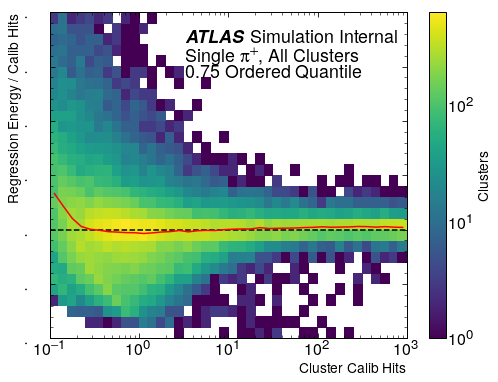

<Figure size 576x432 with 0 Axes>

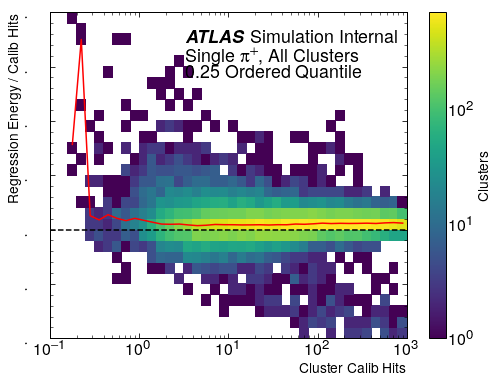

In [36]:
orderedQuant = []
for sel, q in zip([pdata_upper, pdata_lower], [0.75, 0.25]):
    xcenter, rq = ru.responsePlot(pdata['piplus'][pdata['piplus'].test & sel].cluster_ENG_CALIB_TOT,
                      pdata['piplus'][pdata['piplus'].test & sel]['ordered_'+str(q)+'_EoverCalib'], 
                      figfile = plotpath+'ordered_'+str(q)+'_response.pdf', statistic = 'median',
                      xlabel = 'Cluster Calib Hits', ylabel = 'Regression Energy / Calib Hits',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                 {'x': 0.38, 'y': 0.8, 'text': str(q)+' Ordered Quantile'}])
    orderedQuant.append(rq)

<Figure size 576x432 with 0 Axes>

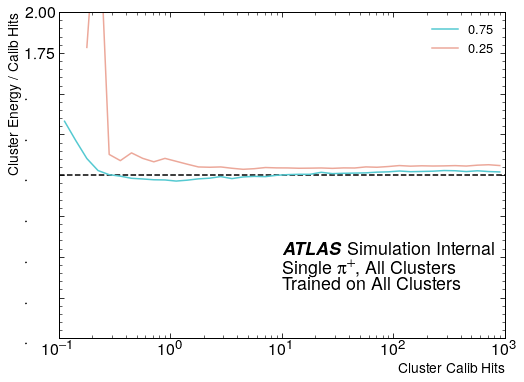

In [34]:
pu.lineOverlay(xcenter=xcenter, lines = orderedQuant,
                labels = [str(q) for q in [0.75,0.25]],
                xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                figfile = plotpath + "ordered_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]],
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])

## Comparison to baseline method for calculating IQR

In [38]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

regressor_All = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=1)
regressor_All.model = load_model(modelpath + 'all.h5')

pdata['piplus']['predict_regressor_All'] = np.exp(scaler_cal['piplus'].inverse_transform(regressor_All.predict(All_input['piplus'])))
pdata['piplus']['predict_regressor_All_EoverCalib'] = pdata['piplus'].predict_regressor_All / pdata['piplus'].cluster_ENG_CALIB_TOT

435967/435967 [==============================] - 3s 7us/sample


<Figure size 576x432 with 0 Axes>

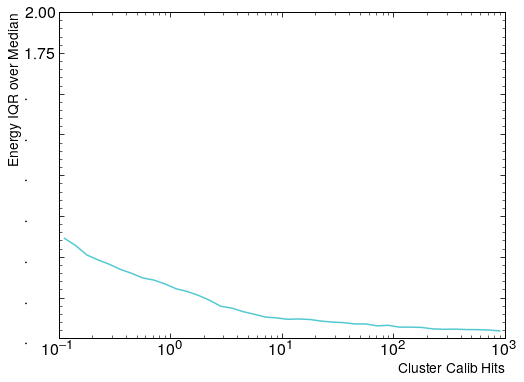

<Figure size 576x432 with 0 Axes>

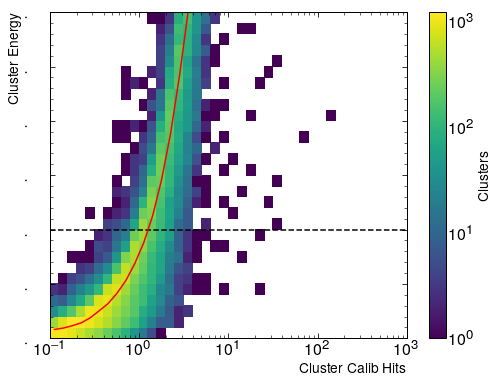

In [62]:
xcenter, iqrOverMedAll = ru.resolutionPlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test].predict_regressor_All_EoverCalib, statistic='iqrOverMed')

xcenter, med = ru.responsePlot(pdata['piplus'][pdata['piplus'].test].cluster_ENG_CALIB_TOT, 
                        pdata['piplus'][pdata['piplus'].test]['quantile_0.5'], statistic='median',
                              ylabel='Cluster Energy', figfile = plotpath + 'median_energy.pdf')

<Figure size 576x432 with 0 Axes>

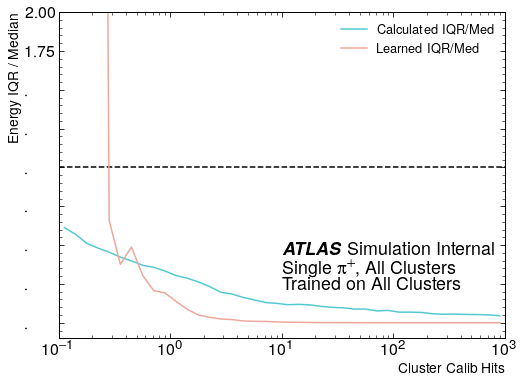

In [58]:
pu.lineOverlay(xcenter=xcenter, lines = [iqrOverMedAll, (orderedQuant[1]-orderedQuant[0])/med],
                labels = ['Calculated IQR/Med','Learned IQR/Med'],
                xlabel = 'Cluster Calib Hits', ylabel = 'Energy IQR / Median',
                figfile = plotpath + "iqr_overlay.pdf",
                extra_lines = [[[0.1,1000],[1,1]]], y_min=-0.1,
                atlas_x = 0.5, atlas_y = 0.3, simulation = True,
                textlist = [{'x': 0.5, 'y': 0.2, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.5, 'y': 0.15, 'text': 'Trained on All Clusters'}])